<h2> Interpretation important latent features - one view </h2>
<h4> Similar latent components vanilla and robust components </h4>

In [2]:
import argparse
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture as GMM
from utils import *
import numpy as np
import torch
import copy
import matplotlib.patches as patches

In [3]:
sd_mdl = torch.load('out/MNIST_vanilla_RKM_h128_oneview.tar', map_location=torch.device('cpu'))

net1 = sd_mdl['net1'].float().cpu()
net3 = sd_mdl['net3'].float().cpu()
net2 = sd_mdl['net2'].float().cpu()
net4 = sd_mdl['net4'].float().cpu()
net1.load_state_dict(sd_mdl['net1_state_dict'])
net3.load_state_dict(sd_mdl['net3_state_dict'])
net2.load_state_dict(sd_mdl['net2_state_dict'])
net4.load_state_dict(sd_mdl['net4_state_dict'])
h = sd_mdl['h'].float().detach().cpu()
s = sd_mdl['s'].float().detach().cpu()
V = sd_mdl['V'].float().detach().cpu()
U = sd_mdl['U'].float().detach().cpu()

sd_mdl_ = torch.load('out/MNIST_adv_RKM_h128_epoch200_pert30_oneview.tar', map_location=torch.device('cpu'))

net1_ = sd_mdl_['net1'].float().cpu()
net3_ = sd_mdl_['net3'].float().cpu()
net2_ = sd_mdl_['net2'].float().cpu()
net4_ = sd_mdl_['net4'].float().cpu()
net1_.load_state_dict(sd_mdl_['net1_state_dict'])
net3_.load_state_dict(sd_mdl_['net3_state_dict'])
net2_.load_state_dict(sd_mdl_['net2_state_dict'])
net4_.load_state_dict(sd_mdl_['net4_state_dict'])
h_ = sd_mdl_['h'].float().detach().cpu()
s_ = sd_mdl_['s'].float().detach().cpu()
V_ = sd_mdl_['V'].float().detach().cpu()
U_ = sd_mdl_['U'].float().detach().cpu()

In [4]:
def generate_back(net1, net3, U, s, h, x):
    """
    Receives an imput as image, goes to the feature space, then latent space, afteerwards back to the feature space and back to the image space.
    Travels the complete model to generate back the image.
    Input: (1, 1, 28, 28) (first dimension needed for the neural network)
    Output: (1, 28, 28)
    """
    #go to the feature space
    output1 = net1(x)

    Lambda = torch.diag(s[:h.size(1)])
    lam_inv = torch.linalg.inv(Lambda)

    #compute h = (Lambda-V_T*V)^-1*U_T*net1(x)
    #note here the computation is done with everything transposed
    latent1 = torch.mm(torch.mm(output1, U),lam_inv.T)

    print(latent1)

    #go back to the feature space U*h
    my_input_net3 = torch.mm(latent1, torch.t(U))

    #go back to the image space
    datax_gen = net3(my_input_net3[0,:])

    return datax_gen

def move_along_h_component(net1, net3, U, s, h, x, index_comp, perturbation):
    """
    Receives an imput as image, goes to the feature space, then latent space, afteerwards back to the feature space and back to the image space.
    Travels the complete model to generate back the image.
    Input: (1, 1, 28, 28) (first dimension needed for the neural network)
    Output: (1, 28, 28)
    """
    #go to the feature space
    output1 = net1(x)

    Lambda = torch.diag(s[:h.size(1)])
    lam_inv = torch.linalg.inv(Lambda)

    #compute h = (Lambda-V_T*V)^-1*U_T*net1(x)
    #note here the computation is done with everything transposed
    latent1 = torch.mm(torch.mm(output1, U),lam_inv.T)

    latent1[0, index_comp] = latent1[0, index_comp] + perturbation*torch.abs(latent1[0, index_comp])

    #go back to the feature space U*h
    my_input_net3 = torch.mm(latent1, torch.t(U))

    #go back to the image space
    datax_gen = net3(my_input_net3[0,:])

    return datax_gen

def move_along_h_component_abs(net1, net3, U, s, h, x, index_comp, perturbation):
    """
    Receives an imput as image, goes to the feature space, then latent space, afteerwards back to the feature space and back to the image space.
    Travels the complete model to generate back the image.
    Input: (1, 1, 28, 28) (first dimension needed for the neural network)
    Output: (1, 28, 28)
    """
    #go to the feature space
    output1 = net1(x)

    Lambda = torch.diag(s[:h.size(1)])
    lam_inv = torch.linalg.inv(Lambda)

    #compute h = (Lambda-V_T*V)^-1*U_T*net1(x)
    #note here the computation is done with everything transposed
    latent1 = torch.mm(torch.mm(output1, U),lam_inv.T)

    latent1[0, index_comp] = latent1[0, index_comp] + perturbation

    #go back to the feature space U*h
    my_input_net3 = torch.mm(latent1, torch.t(U))

    #go back to the image space
    datax_gen = net3(my_input_net3[0,:])

    return datax_gen



In [5]:
# Load a Pre-trained model or saved model ====================
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--filename', type=str, default="out/MNIST_adv_linf_RKM_h_500.tar", help='Enter Filename')
parser.add_argument('--device', type=str, default='cpu', help='Device type: cuda or cpu')
opt_gen = parser.parse_args()

if 'opt' in sd_mdl:
    opt = sd_mdl['opt']
    #self.opt_gen = argparse.Namespace(**vars(opt), **vars(self.opt_gen))
    opt_dict = vars(opt)
    opt_dict.update(vars(opt_gen))  # Update opt_gen with values from opt, prioritizing opt_gen
    opt_gen = argparse.Namespace(**opt_dict)
else:
    opt_gen.mb_size = 200
    
#load the data
opt_gen.shuffle = False
xt, _, _ = get_mnist_dataloader(args=opt_gen)  # loading data without shuffle
xtrain = xt.dataset.train_data[:h.shape[0], :, :, :]  #60.000, 1, 28, 28; h shape 0: 5000
ytrain = xt.dataset.targets[:h.shape[0], :]

image_ori = xtrain[0, :, :, :].float()

c:\Users\gcorl\OneDrive\Documents\KUL\Master 2\Master thesis\Programming\Restricted_Kernel_Machines_Demo_MNIST\myenv\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [6]:
#go to the feature space
image_ori = xtrain[1, :, :, :].float()
print(image_ori.shape)
image_ori = image_ori[None, :, :, :]
assert image_ori.shape == (1, 1, 28, 28)

torch.Size([1, 28, 28])


tensor([[ 0.0218,  0.0100, -0.0164, -0.0175, -0.0212, -0.0020, -0.0091, -0.0014,
          0.0134, -0.0032, -0.0047, -0.0073, -0.0024,  0.0135,  0.0312,  0.0039,
          0.0026,  0.0065, -0.0038,  0.0094,  0.0020,  0.0007,  0.0024, -0.0171,
         -0.0074,  0.0147, -0.0058,  0.0099,  0.0065,  0.0049,  0.0037, -0.0103,
         -0.0013, -0.0024, -0.0079, -0.0080, -0.0210,  0.0141, -0.0036,  0.0004,
          0.0030,  0.0118,  0.0069, -0.0038,  0.0083,  0.0253,  0.0072,  0.0045,
          0.0051, -0.0265,  0.0233,  0.0248,  0.0019,  0.0203, -0.0255, -0.0166,
         -0.0031,  0.0106, -0.0022,  0.0071, -0.0130, -0.0447,  0.0085,  0.0107,
         -0.0034, -0.0167, -0.0129, -0.0176,  0.0184, -0.0084, -0.0004, -0.0021,
         -0.0002, -0.0316, -0.0024,  0.0003, -0.0249, -0.0071,  0.0111,  0.0083,
          0.0010, -0.0158,  0.0219, -0.0031, -0.0111, -0.0288, -0.0057,  0.0064,
          0.0068, -0.0110,  0.0044, -0.0169, -0.0109, -0.0059,  0.0089,  0.0208,
         -0.0165, -0.0145,  

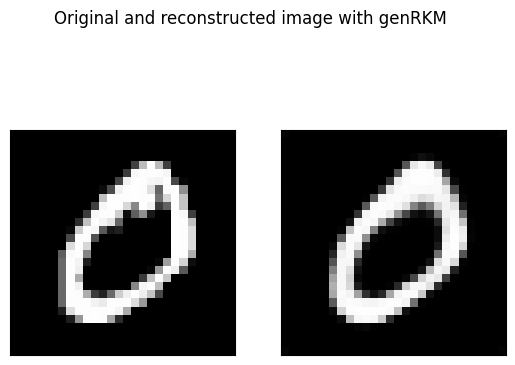

In [7]:
#image_ori_gen = self.__generate_back(self.image_ori)
image_ori_gen = generate_back(net1, net3, U, s, h, image_ori).reshape(1, 28, 28)

model_name = "genRKM"

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_ori[0, 0, :], cmap='Greys_r', vmin=0, vmax=1)
ax[1].imshow(image_ori_gen[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.show()

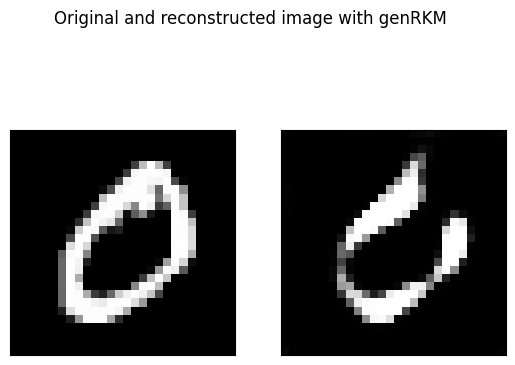

In [8]:
#image_ori_gen = self.__generate_back(self.image_ori)
image_ori_gen = move_along_h_component(net1, net3, U, s, h, image_ori, 4, -4).reshape(1, 28, 28)

model_name = "genRKM"

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_ori[0, 0, :], cmap='Greys_r', vmin=0, vmax=1)
ax[1].imshow(image_ori_gen[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.show()

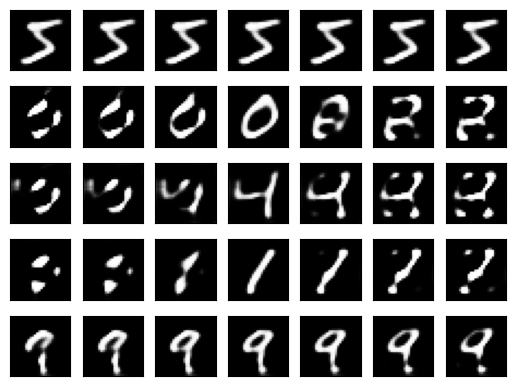

In [8]:
nbr_images = 5
latent_component = 4

fig, ax = plt.subplots(len(range(nbr_images)), len(range(-9, 12, 3)))

for image_idx in range(nbr_images):
    
    image_ori = xtrain[image_idx, :, :, :].float()
    image_ori = image_ori[None, :, :, :]
    assert image_ori.shape == (1, 1, 28, 28)

    counter = 0
    for step in range(-9, 12, 3):
        
        image_ori_gen = move_along_h_component(net1, net3, U, s, h, image_ori, latent_component, step).reshape(1, 28, 28)
        ax[image_idx, counter].imshow(image_ori_gen[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
        ax[image_idx, counter].set_xticks([])
        ax[image_idx, counter].set_yticks([])
        counter += 1
#plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.show()

Vanilla component 4

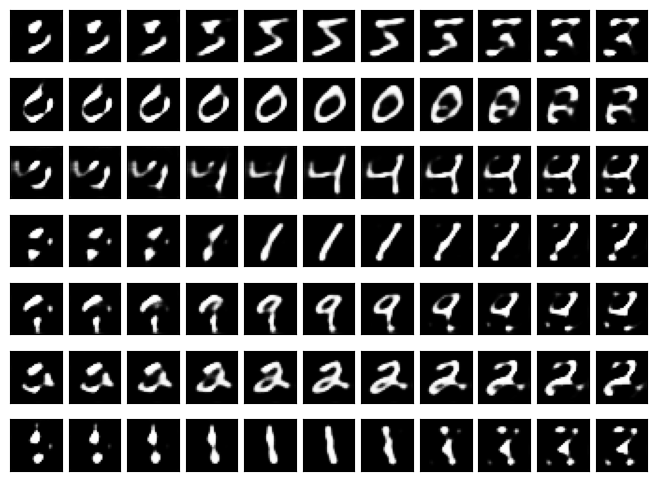

In [9]:
nbr_images = 7
latent_component = 4

fig, ax = plt.subplots(len(range(nbr_images)), len(np.arange(-0.1, 0.12, 0.02)))

for image_idx in range(nbr_images):
    
    image_ori = xtrain[image_idx, :, :, :].float()
    image_ori = image_ori[None, :, :, :]
    assert image_ori.shape == (1, 1, 28, 28)

    counter = 0
    for step in np.arange(-0.1, 0.12, 0.02):
        
        image_ori_gen = move_along_h_component_abs(net1, net3, U, s, h, image_ori, latent_component, step).reshape(1, 28, 28)
        ax[image_idx, counter].imshow(image_ori_gen[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
        ax[image_idx, counter].set_xticks([])
        ax[image_idx, counter].set_yticks([])
        counter += 1
#plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.tight_layout(pad=0.1, h_pad=0.001, w_pad=0.5)

plt.subplots_adjust(hspace=0.01)
plt.show()

Robust component 3

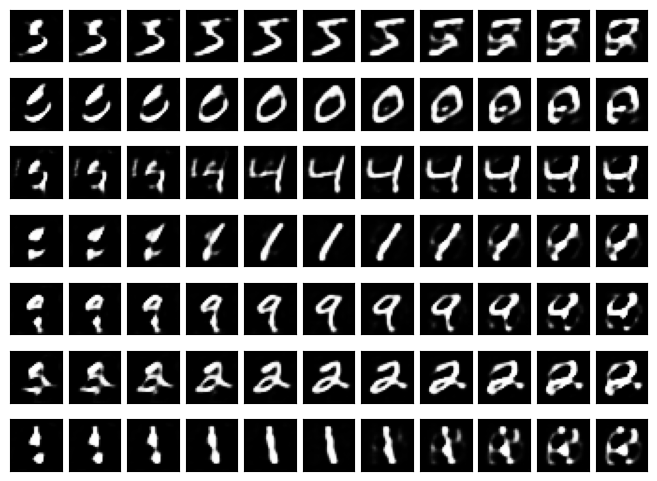

In [10]:
nbr_images = 7
latent_component = 3

fig, ax = plt.subplots(len(range(nbr_images)), len(np.arange(-0.1, 0.12, 0.02)))

for image_idx in range(nbr_images):
    
    image_ori = xtrain[image_idx, :, :, :].float()
    image_ori = image_ori[None, :, :, :]
    assert image_ori.shape == (1, 1, 28, 28)

    counter = 0
    for step in np.arange(-0.1, 0.12, 0.02):
        
        image_ori_gen = move_along_h_component_abs(net1_, net3_, U_, s_, h_, image_ori, latent_component, step).reshape(1, 28, 28)
        ax[image_idx, counter].imshow(image_ori_gen[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
        ax[image_idx, counter].set_xticks([])
        ax[image_idx, counter].set_yticks([])
        counter += 1
#plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.tight_layout(pad=0.1, h_pad=0.001, w_pad=0.5)

plt.subplots_adjust(hspace=0.01)
plt.show()

Second pair


Vanilla model

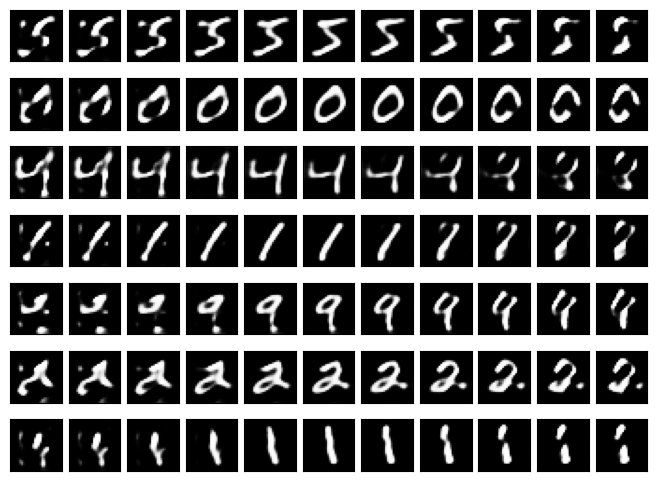

In [11]:
nbr_images = 7
latent_component = 6

fig, ax = plt.subplots(len(range(nbr_images)), len(np.arange(-0.1, 0.12, 0.02)))

for image_idx in range(nbr_images):
    
    image_ori = xtrain[image_idx, :, :, :].float()
    image_ori = image_ori[None, :, :, :]
    assert image_ori.shape == (1, 1, 28, 28)

    counter = 0
    for step in np.arange(-0.1, 0.12, 0.02):
        
        image_ori_gen = move_along_h_component_abs(net1, net3, U, s, h, image_ori, latent_component, step).reshape(1, 28, 28)
        ax[image_idx, counter].imshow(image_ori_gen[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
        ax[image_idx, counter].set_xticks([])
        ax[image_idx, counter].set_yticks([])
        counter += 1
#plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.tight_layout(pad=0.1, h_pad=0.001, w_pad=0.5)

plt.subplots_adjust(hspace=0.01)
plt.show()

Robust model

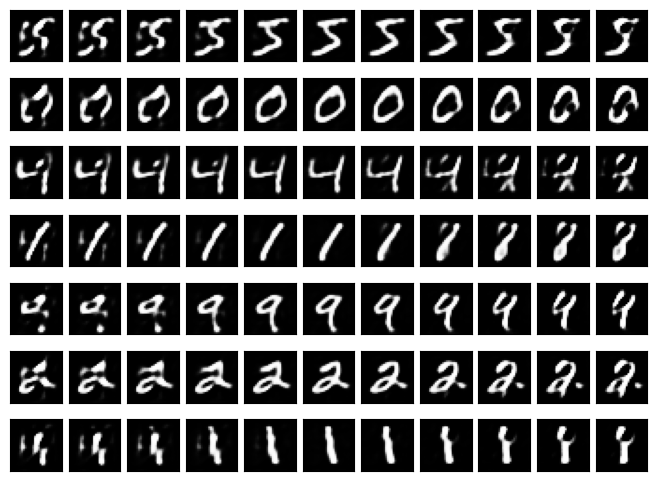

In [12]:
nbr_images = 7
latent_component = 10

fig, ax = plt.subplots(len(range(nbr_images)), len(np.arange(-0.1, 0.12, 0.02)))

for image_idx in range(nbr_images):
    
    image_ori = xtrain[image_idx, :, :, :].float()
    image_ori = image_ori[None, :, :, :]
    assert image_ori.shape == (1, 1, 28, 28)

    counter = 0
    for step in np.arange(-0.1, 0.12, 0.02):
        
        image_ori_gen = move_along_h_component_abs(net1_, net3_, U_, s_, h_, image_ori, latent_component, step).reshape(1, 28, 28)
        ax[image_idx, counter].imshow(image_ori_gen[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
        ax[image_idx, counter].set_xticks([])
        ax[image_idx, counter].set_yticks([])
        counter += 1
#plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.tight_layout(pad=0.1, h_pad=0.001, w_pad=0.5)

plt.subplots_adjust(hspace=0.01)
plt.show()

Third pair


Vanilla model

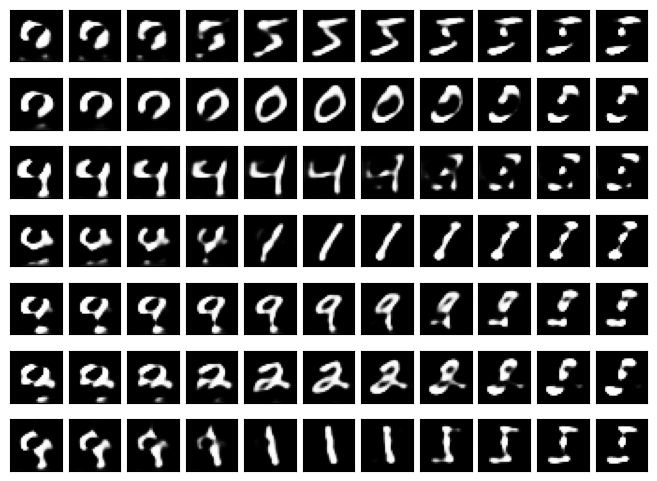

In [16]:
nbr_images = 7
latent_component = 1

fig, ax = plt.subplots(len(range(nbr_images)), len(np.arange(-0.1, 0.12, 0.02)))

for image_idx in range(nbr_images):
    
    image_ori = xtrain[image_idx, :, :, :].float()
    image_ori = image_ori[None, :, :, :]
    assert image_ori.shape == (1, 1, 28, 28)

    counter = 0
    for step in np.arange(-0.1, 0.12, 0.02):
        
        image_ori_gen = move_along_h_component_abs(net1, net3, U, s, h, image_ori, latent_component, step).reshape(1, 28, 28)
        ax[image_idx, counter].imshow(image_ori_gen[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
        ax[image_idx, counter].set_xticks([])
        ax[image_idx, counter].set_yticks([])
        counter += 1
#plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.tight_layout(pad=0.1, h_pad=0.001, w_pad=0.5)

plt.subplots_adjust(hspace=0.01)
plt.show()

Robust model


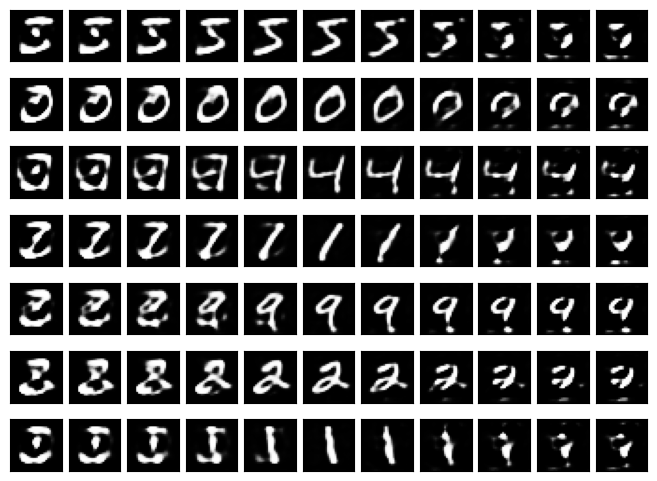

In [15]:
nbr_images = 7
latent_component = 0

fig, ax = plt.subplots(len(range(nbr_images)), len(np.arange(-0.1, 0.12, 0.02)))

for image_idx in range(nbr_images):
    
    image_ori = xtrain[image_idx, :, :, :].float()
    image_ori = image_ori[None, :, :, :]
    assert image_ori.shape == (1, 1, 28, 28)

    counter = 0
    for step in np.arange(-0.1, 0.12, 0.02):
        
        image_ori_gen = move_along_h_component_abs(net1_, net3_, U_, s_, h_, image_ori, latent_component, step).reshape(1, 28, 28)
        ax[image_idx, counter].imshow(image_ori_gen[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
        ax[image_idx, counter].set_xticks([])
        ax[image_idx, counter].set_yticks([])
        counter += 1
#plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.tight_layout(pad=0.1, h_pad=0.001, w_pad=0.5)

plt.subplots_adjust(hspace=0.01)
plt.show()

Robust model flipped

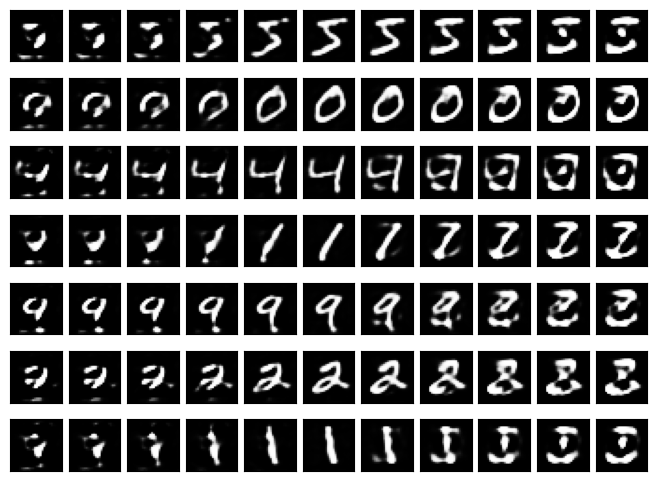

In [9]:
nbr_images = 7
latent_component = 0

fig, ax = plt.subplots(len(range(nbr_images)), len(np.arange(-0.1, 0.12, 0.02)))

for image_idx in range(nbr_images):
    
    image_ori = xtrain[image_idx, :, :, :].float()
    image_ori = image_ori[None, :, :, :]
    assert image_ori.shape == (1, 1, 28, 28)

    counter = 0
    for step in np.arange(0.1, -0.12, -0.02):
        
        image_ori_gen = move_along_h_component_abs(net1_, net3_, U_, s_, h_, image_ori, latent_component, step).reshape(1, 28, 28)
        ax[image_idx, counter].imshow(image_ori_gen[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
        ax[image_idx, counter].set_xticks([])
        ax[image_idx, counter].set_yticks([])
        counter += 1
#plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.tight_layout(pad=0.1, h_pad=0.001, w_pad=0.5)

plt.subplots_adjust(hspace=0.01)
plt.show()

Very dissimilar pair

Vanilla model

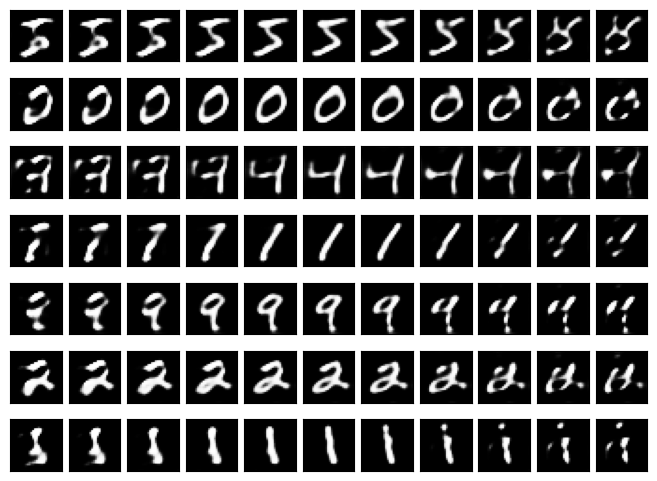

In [10]:
nbr_images = 7
latent_component = 9

fig, ax = plt.subplots(len(range(nbr_images)), len(np.arange(-0.1, 0.12, 0.02)))

for image_idx in range(nbr_images):
    
    image_ori = xtrain[image_idx, :, :, :].float()
    image_ori = image_ori[None, :, :, :]
    assert image_ori.shape == (1, 1, 28, 28)

    counter = 0
    for step in np.arange(-0.1, 0.12, 0.02):
        
        image_ori_gen = move_along_h_component_abs(net1, net3, U, s, h, image_ori, latent_component, step).reshape(1, 28, 28)
        ax[image_idx, counter].imshow(image_ori_gen[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
        ax[image_idx, counter].set_xticks([])
        ax[image_idx, counter].set_yticks([])
        counter += 1
#plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.tight_layout(pad=0.1, h_pad=0.001, w_pad=0.5)

plt.subplots_adjust(hspace=0.01)
plt.show()

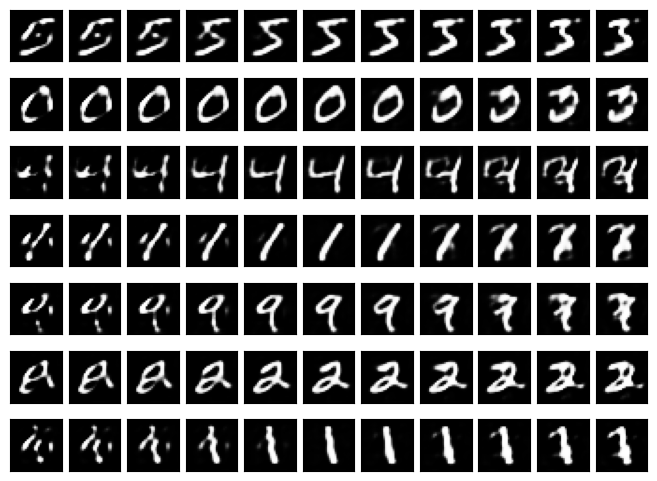

In [11]:
nbr_images = 7
latent_component = 8

fig, ax = plt.subplots(len(range(nbr_images)), len(np.arange(-0.1, 0.12, 0.02)))

for image_idx in range(nbr_images):
    
    image_ori = xtrain[image_idx, :, :, :].float()
    image_ori = image_ori[None, :, :, :]
    assert image_ori.shape == (1, 1, 28, 28)

    counter = 0
    for step in np.arange(-0.1, 0.12, 0.02):
        
        image_ori_gen = move_along_h_component_abs(net1_, net3_, U_, s_, h_, image_ori, latent_component, step).reshape(1, 28, 28)
        ax[image_idx, counter].imshow(image_ori_gen[0, :].detach().numpy(), cmap='Greys_r', vmin=0, vmax=1)
        ax[image_idx, counter].set_xticks([])
        ax[image_idx, counter].set_yticks([])
        counter += 1
#plt.suptitle(f"Original and reconstructed image with {model_name}")
plt.tight_layout(pad=0.1, h_pad=0.001, w_pad=0.5)

plt.subplots_adjust(hspace=0.01)
plt.show()